In [1]:
#Import the libraries
import math
import os
import pandas_datareader as pdr
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
df=pd.read_csv('ACN1.csv') 
#Show the data 
df

,Unnamed: 0,symbol,Date,Open,High,Low,close,Adj close,Volume
0,0,ACN,2/3/2021,248.190002,250.110001,246.589996,248.369995,245.539291,2470400
1,1,ACN,2/4/2021,249.559998,253.029999,246.910004,253.009995,250.126404,1702200
2,2,ACN,2/5/2021,254.089996,255.750000,252.160004,253.539993,250.650345,1497700
3,3,ACN,2/8/2021,253.919998,257.350006,253.759995,257.309998,254.377396,1508700
4,4,ACN,2/9/2021,256.309998,258.809998,255.610001,257.679993,254.743179,1542600
...,...,...,...,...,...,...,...,...,...
248,248,ACN,1/27/2022,337.529999,341.730011,331.010010,333.359985,333.359985,2778000
249,249,ACN,1/28/2022,333.899994,343.059998,327.170013,342.850006,342.850006,2457400
250,250,ACN,1/31/2022,345.000000,353.700012,343.540009,353.579987,353.579987,3159300
251,251,ACN,2/1/2022,354.220001,356.700012,348.880005,353.420013,353.420013,2087200


In [3]:
df.shape

(253, 9)

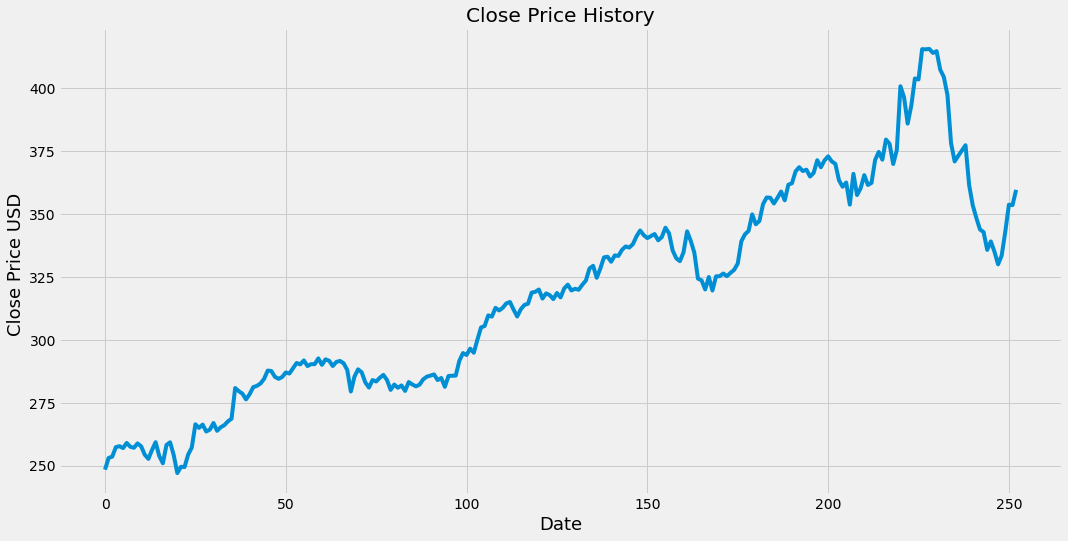

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ',fontsize=18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [8]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

143/143 [==============================] - 8s 28ms/step - loss: 0.0096


In [13]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [14]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [15]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [16]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [17]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

34.48580409531167

C:\Users\chinu\AppData\Local\Temp/ipykernel_12168/4147573702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


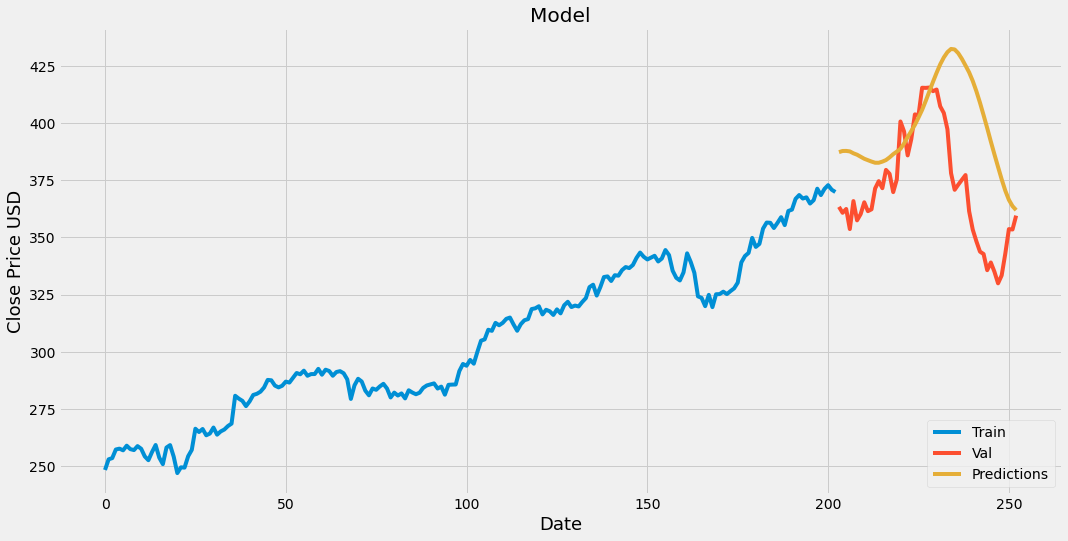

In [18]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
#Show the valid and predicted prices
valid

,close,Predictions
203,363.299988,387.205658
204,360.700012,387.706940
205,362.369995,387.739380
206,353.600006,387.517853
207,365.820007,386.694885
208,357.399994,386.080109
209,360.140015,385.194153
210,365.299988,384.307129
211,361.420013,383.687836
212,362.230011,383.084900


In [20]:
#Get the quote
acn_quote = pd.read_csv('ACN1.csv') 
#Create a new dataframe
new_df = acn_quote.filter(['close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print('The predicted price for next day',pred_price)
print()


The predicted price for next day [[361.20612]]



In [21]:
acn_quote2 = web.DataReader('ACN', data_source='yahoo', start='2022-02-03', end='2022-02-03')
print(acn_quote2['Close'])

Date
2022-02-02    359.470001
2022-02-03    345.549988
Name: Close, dtype: float64
